In [59]:
import matplotlib.pyplot as plt
from matplotlib import cm
from skimage.filters import gaussian, sobel, sobel_h, sobel_v
# from skimage.morphology import skeletonize
from skimage.transform import hough_line, hough_line_peaks
import numpy as np

In [103]:
CALIBRATION_LEFT_FILEPATH = '../data/2025-06-09-40uL_250um/calibration_left.jpg'
TEST_IMAGE = '../data/toys/line_outline.png'


# im = plt.imread(CALIBRATION_LEFT_FILEPATH)[:,:,0]
im = plt.imread(TEST_IMAGE)[:,:,0]


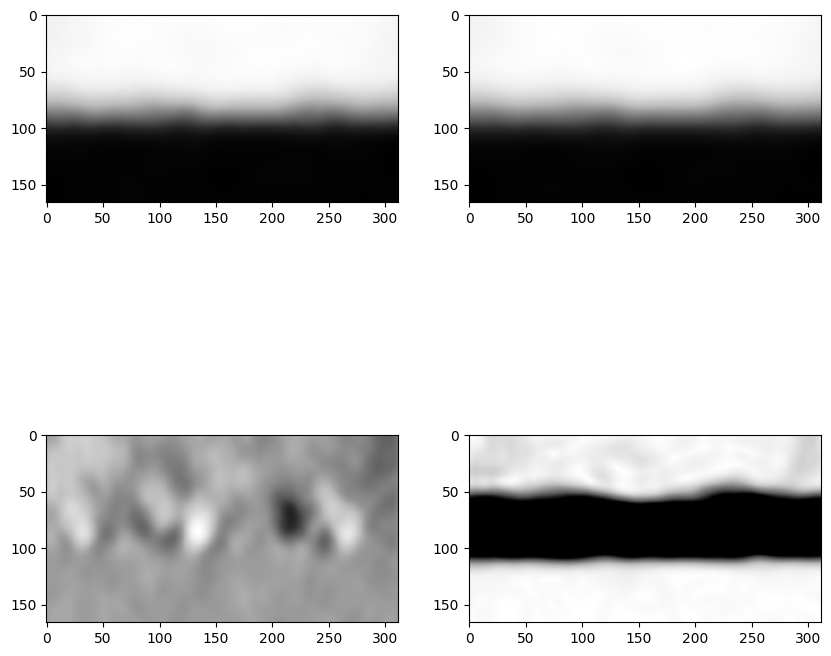

In [104]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.imshow(im,cmap='Greys')
plt.subplot(2,2,2)
im_blur = gaussian(im,sigma=5)
plt.imshow(im_blur,cmap='Greys')
plt.subplot(2,2,3)
plt.imshow(sobel_v(im_blur)*100,vmax=1,cmap='Greys')
plt.subplot(2,2,4)
plt.imshow(sobel(im_blur)*100,vmax=1,cmap='Greys')

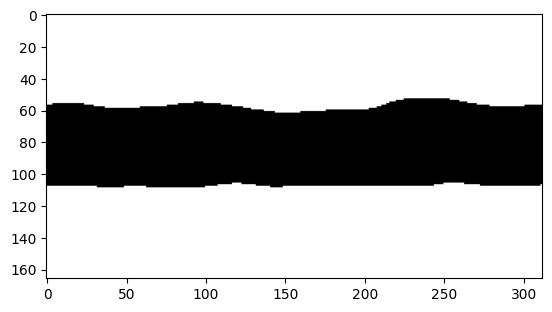

In [105]:
# from skimage.morphology import skeletonize

im_sobel = sobel(im_blur)
thresholded = im_sobel < 0.01
# thresholded = 255 - thresholded
# skeleton = skeletonize(thresholded)
plt.imshow(thresholded,cmap=cm.grey)

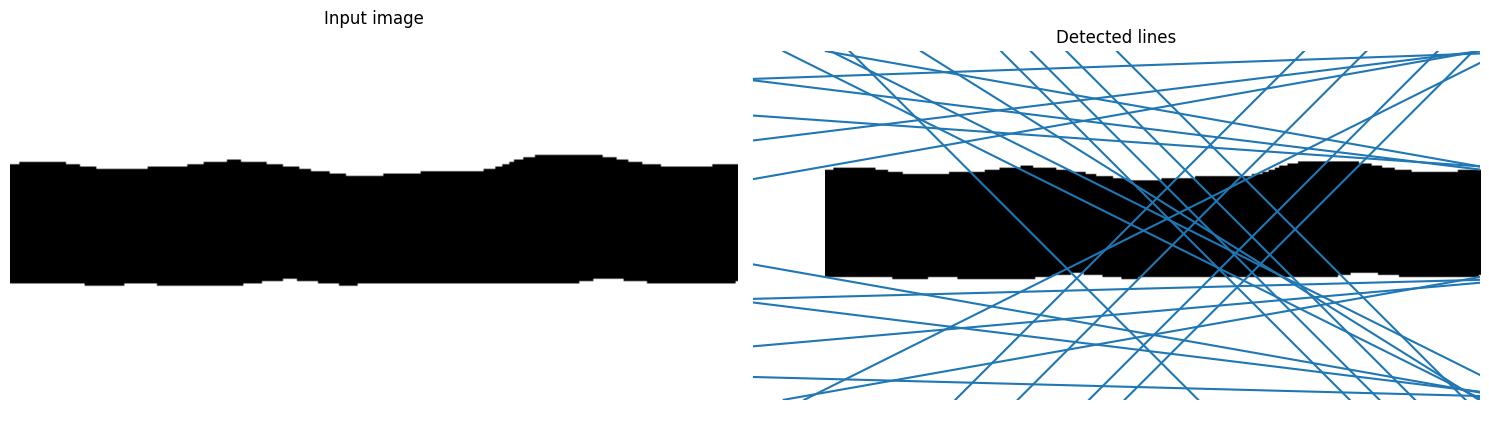

In [106]:
tested_angles = np.linspace(-(np.pi / 2)+(np.pi/2), (np.pi / 2)+(np.pi/2), 360, endpoint=False)

h, theta, d = hough_line(thresholded, theta=tested_angles)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
ax = axes.ravel()
ax[0].imshow(thresholded, cmap=cm.gray)
ax[0].set_title('Input image')
ax[0].set_axis_off()

ax[1].imshow(thresholded, cmap=cm.gray)
ax[1].set_ylim((thresholded.shape[0], 0))
ax[1].set_axis_off()
ax[1].set_title('Detected lines')

for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    (x0, y0) = dist * np.array([np.cos(angle), np.sin(angle)])
    ax[1].axline((x0, y0), slope=np.tan(angle + np.pi / 2))

plt.tight_layout()
plt.show()


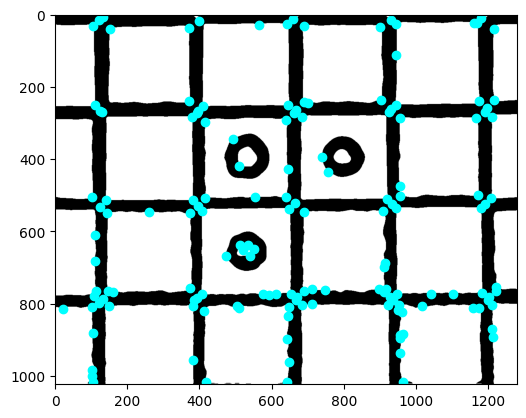

In [102]:
from skimage.feature import corner_harris, corner_subpix, corner_peaks

coords = corner_peaks(corner_harris(thresholded), min_distance=5, threshold_rel=0.1)
coords_subpix = corner_subpix(thresholded, coords, window_size=13)

fig, ax = plt.subplots()
ax.imshow(thresholded, cmap=plt.cm.gray)
ax.plot(
    coords[:, 1], coords[:, 0], color='cyan', marker='o', linestyle='None', markersize=6
)